<a href="https://colab.research.google.com/github/Dhadheechi/cv/blob/main/diffuision_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install -q diffusers

In [3]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [4]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.11MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.44MB/s]


In [5]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([1, 4, 4, 9, 1, 3, 2, 2])


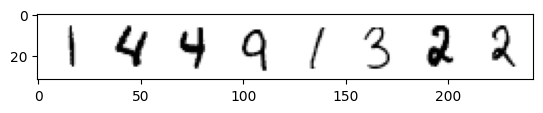

In [6]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

In [7]:
def corrupt(x, amount):
  """Corrupt the input x by mixing it with noise according to 'account'"""
  noise = torch.rand_like(x) # has shape (batch_size, channel, height, width)
  amount = amount.view(-1, 1, 1, 1) # sort the shape so that broadcasting works; a different amount of noise for each input image in the batch
  return (1 - amount) * x + (amount)* noise

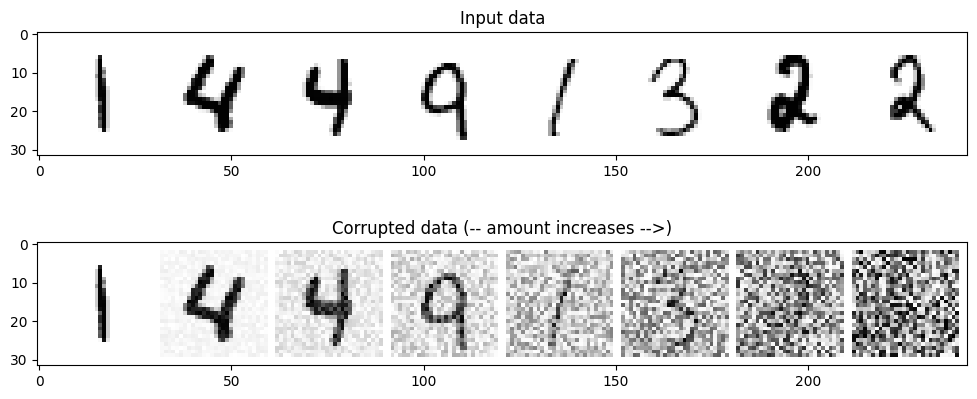

In [8]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

In [9]:
class BasicUNet(nn.Module): # note that the upsampling block executes its actions in the reverse order of the downsampling block
  """A minimal U-Net implementation."""
  def __init__(self, in_channels=1, out_channels=1):
    super().__init__()
    self.down_layers = torch.nn.ModuleList([
        nn.Conv2d(in_channels, 32, kernel_size=5, padding=2), # this combination of kernel size and padding doesn't reduce the size of the output; we also use no stride
        nn.Conv2d(32, 64, kernel_size=5, padding=2),
        nn.Conv2d(64, 64, kernel_size=5, padding=2)
    ])
    self.up_layers = torch.nn.ModuleList([
        nn.Conv2d(64, 64, kernel_size=5, padding=2),
        nn.Conv2d(64, 32, kernel_size=5, padding=2),
        nn.Conv2d(32, 1, kernel_size=5, padding=2)
    ])

    self.act = nn.SiLU()
    self.downscale = nn.MaxPool2d(2)
    self.upscale = nn.Upsample(scale_factor=2.0)

  def forward(self, x):
    h = []
    for i, l in enumerate(self.down_layers):
      x = self.act(l(x)) # store the activation for all but the last layer in the downsampling block
      if i < 2:
        h.append(x)
        x = self.downscale(x) # no downscaling for the last layer

    for i, l in enumerate(self.up_layers):
      if i > 0: # for all except the first up layer, we do upsampling and add the skip connection
        x = self.upscale(x)
        x += h.pop()

      x = self.act(l(x))

    return x

In [10]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape # has the same shape as the input

torch.Size([8, 1, 28, 28])

In [11]:
sum([p.numel() for p in net.parameters()])

309057

Finished epoch 0. Average loss for this epoch: 0.026672
Finished epoch 1. Average loss for this epoch: 0.020031
Finished epoch 2. Average loss for this epoch: 0.018270


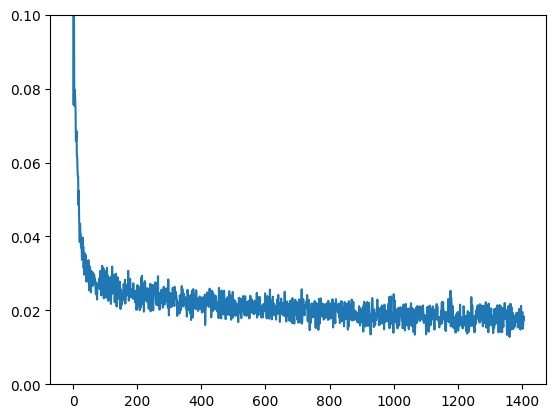

In [12]:
# Plan: Corrupt the clean images by random amounts and measure how well the model is able to reproduce the clean images (i.e., denoising the images)

batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

n_epochs = 3

net = BasicUNet()
net.to(device)

loss_fn = nn.MSELoss()

# Optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []

for epoch in range(n_epochs):
  for x,y in train_dataloader:

    # Get the data and prepare the corrupted version
    x = x.to(device)
    noise_amounts = torch.rand(x.shape[0]).to(device)
    noisy_x = corrupt(x, noise_amounts)

    pred = net(noisy_x)

    loss = loss_fn(pred, x) # how close is the prediction to clean x? We could also train the model to predict the noise instead, which we could then subtract from noisy_x to get the approximated true x

    # backprop and update the params
    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
  avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
  print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

plt.plot(losses)
plt.ylim(0, 0.1);


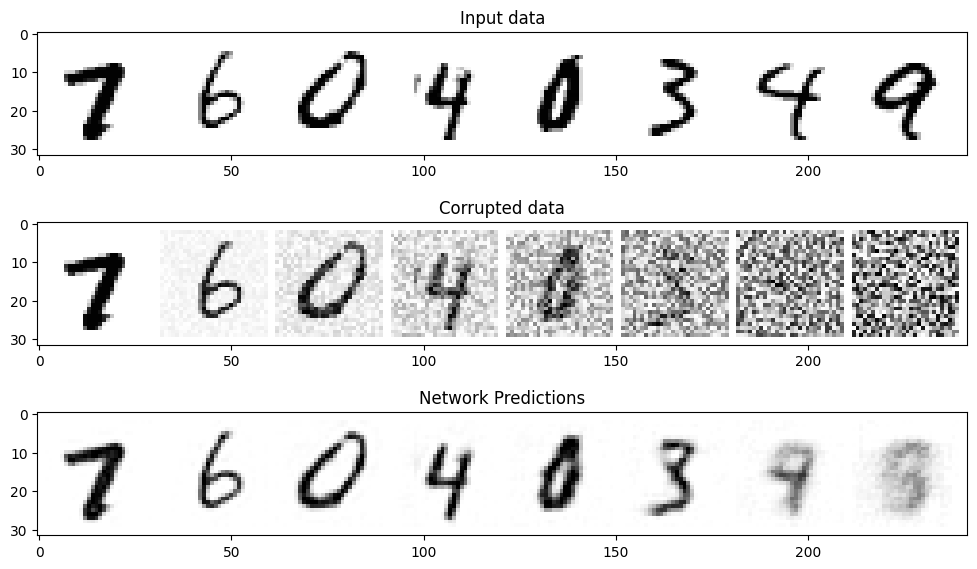

In [13]:
# visualizing model predictions on noisy inputs

x, y = next(iter(train_dataloader))
x = x[:8]

amount = torch.linspace(0, 1, x.shape[0]) # left to right -> more corruption
noised_x = corrupt(x, amount)

with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

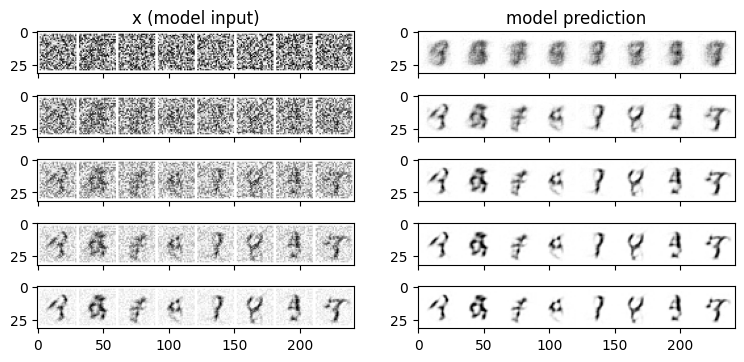

In [14]:
# start from random and move 1/5th of the way there each time
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
  with torch.no_grad():
    pred = net(x) # predict the denoised x0

  pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
  mix_factor = 1 / (n_steps - i) # increases as the number of steps increases
  x = x * (1 - mix_factor) + pred * mix_factor # move part of the way there; at the beginning it's only 20% of the prediction but at the end it is 100% of the prediction
  step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys') # this is the mixture of the latest prediction and it's input -- it gets less
    # noisier as the number of timesteps increases
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys') # this is the supposed "clean" prediction -- at each step it
    # predicts the fully denoised output at each step; it's not used directly but fed into the mixture

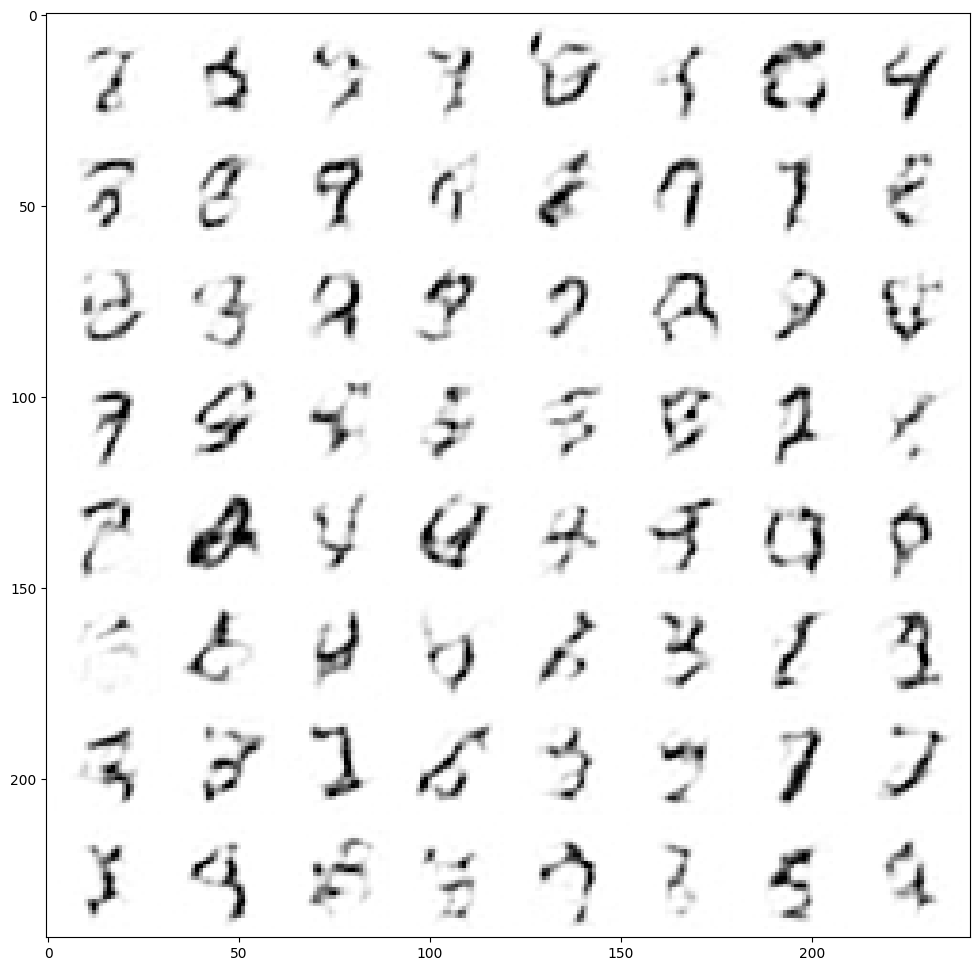

In [15]:
# n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

In [16]:
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,
    out_channels=1,
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [17]:
sum([p.numel() for p in model.parameters()])

1707009

Finished epoch 0. Average loss for this epoch: 0.020440
Finished epoch 1. Average loss for this epoch: 0.013181
Finished epoch 2. Average loss for this epoch: 0.011797


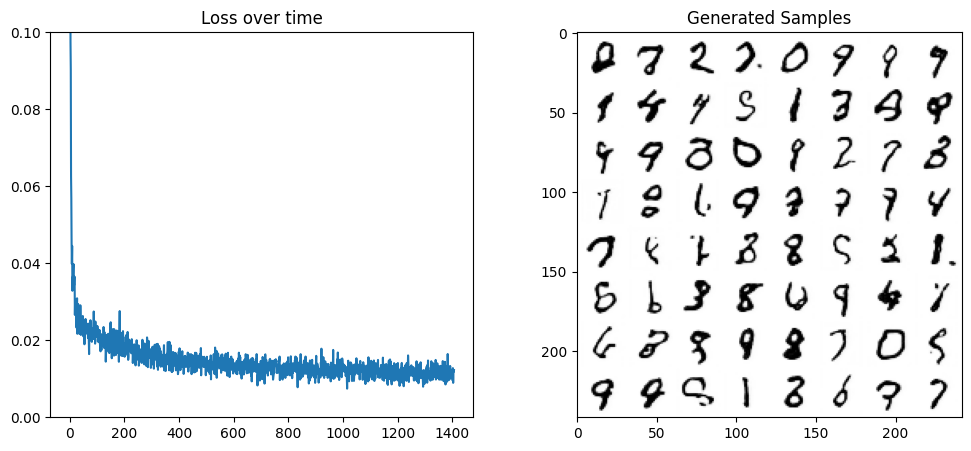

In [18]:
# Trying UNet2DModel instead of BasicUNet

batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');